# Python and Neo4j for Network Science

In this notebook we'll look at how to combine Python and Neo4j to explore a network/graph containing interactions between Game of Thrones characters.

In [37]:
from neo4j.v1 import GraphDatabase, basic_auth
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [38]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", "neo"))

## How many characters do we have?

To get started let's run the query which calculates the number of characters in Game of Thrones and print it to the screen.

In [39]:
query = """\
MATCH (c:Character)
RETURN count(c) AS totalCharacters
"""

with driver.session() as session:
    result = session.run(query)
    row = result.peek()
    print("Number of characters: {0}".format(row["totalCharacters"]))        

Number of characters: 187


## What's the distribution of interactions by characters? 

We can combine Neo4j and matplotlib to create a histogram that shows how interactions are spread out across our characters.

In [40]:
query = """\
MATCH (c:Character)-->()
RETURN c, count(*) AS numberOfInteractions
"""

In [41]:
with driver.session() as session:
    result = session.run(query)
    interactions = [row["numberOfInteractions"] for row in result]        

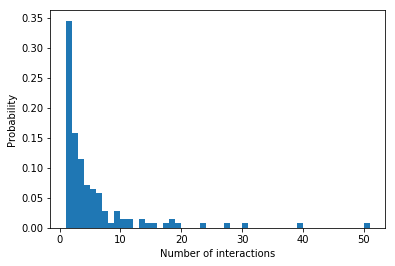

In [42]:
plt.hist(interactions, normed=True, bins=50)
plt.ylabel('Probability');
plt.xlabel('Number of interactions');
plt.show()